<a href="https://colab.research.google.com/github/mani2106/Credit-Card-Default/blob/main/credit_card_default_data_analysis_and_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Upload the data and unzip it

In [1]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: application_record.csv  
  inflating: credit_record.csv       


# Import libraries and Data

In [2]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for the yeo-johnson transformation
import scipy.stats as stats

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

Display application_record data

In [35]:
app_data = pd.read_csv('/content/application_record.csv')

app_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [4]:
# rows and columns of the data
print(app_data.shape)

(438557, 18)


In [5]:
cred_rec = pd.read_csv('/content/credit_record.csv')
cred_rec.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [6]:
cred_rec.shape

(1048575, 3)

# Data Analysis

## Target Analysis

Let's explore the objective, in our case we don't have a concrete objective so Let's check the information provided.

**STATUS** col info
* 0: **1-29 days** past due
* 1: **30-59 days** past due
* 2: **60-89 days** overdue
* 3: **90-119 days** overdue
* 4: **120-149 days** overdue
* 5: Overdue or bad debts, write-offs for more than **150 days**
* C: paid off that month
* X: No loan for the month

We should probably ignore `X` since we might not need data for months where no loan was taken.

It is understandable that for **STATUS** codes `0-5` the loan is overdue, in terms of `good` and `bad` applicant we can say that if an applicant is probably a `bad` applicant. Let's convert the target based on this assumption.

In [7]:
# Filter X months
cred_rec = cred_rec[cred_rec['STATUS'] != 'X']

In [8]:
# check shape after filter
cred_rec.shape

(839345, 3)

In [9]:
cred_rec['TARGET'] = cred_rec['STATUS'].apply(lambda x: 'GOOD' if x == 'C' else 'BAD')

<ipython-input-9-b4440ac0b6ae>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cred_rec['TARGET'] = cred_rec['STATUS'].apply(lambda x: 'GOOD' if x == 'C' else 'BAD')


In [10]:
cred_rec.head()

,ID,MONTHS_BALANCE,STATUS,TARGET
1,5001711,-1,0,BAD
2,5001711,-2,0,BAD
3,5001711,-3,0,BAD
4,5001712,0,C,GOOD
5,5001712,-1,C,GOOD


Since the given data is on a **monthly** basis, let's see for each applicant the number of months they been on time to pay back the dues

In [11]:
cred_rec.groupby('ID')['TARGET'].value_counts()

ID       TARGET
5001711  BAD        3
5001712  BAD       10
         GOOD       9
5001717  BAD       17
         GOOD       5
                   ..
5150482  GOOD       6
5150484  BAD       12
         GOOD       1
5150485  BAD        2
5150487  GOOD      30
Name: TARGET, Length: 62739, dtype: int64

From the gist, We can see that there some applicants 
* **5001711** with only a **few** months of transaction history and some applicants.
* **5001717**, with huge number of transactions.

We should keep this in mind because, without much of a transaction history it is **hard** to determine whether the applicant is `GOOD` or `BAD`.

Depending on the situation, we could approve cards for people with not much of transaction history, but with a **low spend limit** or don't approve them at all.

Let's check the average of number of months in transactions and applicants with most and least number of transactions.

In [12]:
count_by_id = cred_rec.groupby('ID').size()
count_by_id.describe()

count    41449.000000
mean        20.250066
std         15.174233
min          1.000000
25%          8.000000
50%         16.000000
75%         30.000000
max         61.000000
dtype: float64

So,
- on average, we have `20` transactions per applicant
- minimum transaction count is `1`
- maximum transaction count is `61`

### Focusing on a defined subset of applicants

To make this problem simpler, I am going to consider only applicants with atleast `12` months of transaction history (**24891**), by doing this we are can be sure that we have reliable history of transactions to work with.

In [13]:
sum(count_by_id >= 12)

26095

In [14]:
valid_ids = count_by_id[count_by_id >= 12].index.tolist()

Filter IDs with less than 12 month transaction history

In [15]:
filt_cred_rec = cred_rec[cred_rec['ID'].isin(valid_ids)]
filt_cred_rec.ID.nunique()

26095

In [16]:
filt_cred_rec

,ID,MONTHS_BALANCE,STATUS,TARGET
4,5001712,0,C,GOOD
5,5001712,-1,C,GOOD
6,5001712,-2,C,GOOD
7,5001712,-3,C,GOOD
8,5001712,-4,C,GOOD
...,...,...,...,...
1048570,5150487,-25,C,GOOD
1048571,5150487,-26,C,GOOD
1048572,5150487,-27,C,GOOD
1048573,5150487,-28,C,GOOD


Join the Count data with the main dataframe

In [17]:
targ_cred_rec = filt_cred_rec.merge(count_by_id.rename('COUNT'), how='left', on='ID')
targ_cred_rec.head()

,ID,MONTHS_BALANCE,STATUS,TARGET,COUNT
0,5001712,0,C,GOOD,19
1,5001712,-1,C,GOOD,19
2,5001712,-2,C,GOOD,19
3,5001712,-3,C,GOOD,19
4,5001712,-4,C,GOOD,19


### Fixing the Target / Objective

Count the `GOOD` and `BAD` transactions

**!! IMPORTANT !!**

Since we don't have a concrete **TARGET** variable to model our problem,

We should create an objective / formula to calculate some kind of score or value which can be used to differentiate `GOOD` and `BAD` applicants.

Let's consider that if the number of `GOOD` transactions is greater than 20% of total transactions

In [18]:
good_bad_cnts = targ_cred_rec.groupby('ID')['TARGET'].value_counts()
good_bad_cnts

ID       TARGET
5001712  BAD       10
         GOOD       9
5001717  BAD       17
         GOOD       5
5001718  BAD       26
                   ..
5150482  BAD       12
         GOOD       6
5150484  BAD       12
         GOOD       1
5150487  GOOD      30
Name: TARGET, Length: 44948, dtype: int64

Let's pivot this data with the `TARGET` variable to make the calculations easier

In [19]:
app_profile = good_bad_cnts.to_frame(name='COUNTS')\
    .reset_index()\
    .pivot(index='ID', columns='TARGET', values='COUNTS')\
    .fillna(0)

app_profile['TOTAL'] = app_profile['GOOD'] + app_profile['BAD']

In [20]:
app_profile.head()

TARGET,BAD,GOOD,TOTAL
ID,,,
5001712,10.0,9.0,19.0
5001717,17.0,5.0,22.0
5001718,26.0,3.0,29.0
5001719,2.0,41.0,43.0
5001720,36.0,0.0,36.0


Now it will be easier to perform the calculations

In [21]:
app_profile['ML_TARG'] = (app_profile['GOOD'] / app_profile['TOTAL']) > 0.2
app_profile['ML_TARG'] = app_profile['ML_TARG'].astype(int)

In [22]:
app_profile['ML_TARG'].value_counts()

1    18653
0     7442
Name: ML_TARG, dtype: int64

In [23]:
app_profile.drop(['BAD', 'GOOD', 'TOTAL'], inplace=True, axis='columns')
app_profile.head()

TARGET,ML_TARG
ID,
5001712,1
5001717,1
5001718,0
5001719,1
5001720,0


## Meta Analysis

Let's check for any null data and data types

In [24]:
cred_rec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 839345 entries, 1 to 1048574
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ID              839345 non-null  int64 
 1   MONTHS_BALANCE  839345 non-null  int64 
 2   STATUS          839345 non-null  object
 3   TARGET          839345 non-null  object
dtypes: int64(2), object(2)
memory usage: 32.0+ MB


So we don't have any null data, let's see if that's the case with the applicant record

In [25]:
app_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

We have some missing entries in `OCCUPATION_TYPE`, but apart from that there is no missing data

## Merge with Target data

Now let's combine the target data from our previous section.

In [36]:
app_data.shape

(438557, 18)

In [37]:
# Filter the applicant IDs with a specified number of transactions
app_data = app_data[app_data['ID'].isin(valid_ids)]
app_data = app_data.merge(app_profile, on='ID')
app_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,ML_TARG
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,1
3,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1
4,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1


In [38]:
app_data.shape

(20012, 19)

I see that there are some duplicate records with different `IDs`.
Let's see that is true.

# Data Preprocessing

## Duplicate data check

In [39]:
app_data['DUPE'] = app_data.drop('ID', axis='columns').duplicated().to_list()

In [40]:
app_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,ML_TARG,DUPE
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1,False
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1,True
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,1,False
3,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1,False
4,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1,True


In [41]:
app_data['DUPE'].value_counts()

True     11017
False     8995
Name: DUPE, dtype: int64

As I had seen before there are some duplicate entries in the data, this means that there are some people who may have applied multiple times.

We should remove those rows, and we can also keep the `DUPE` column as a feature to indicate the applicant has already applied and see it has any impact in the final model.

In [42]:
app_data = app_data[~app_data['DUPE']]
app_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8995 entries, 0 to 20011
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   8995 non-null   int64  
 1   CODE_GENDER          8995 non-null   object 
 2   FLAG_OWN_CAR         8995 non-null   object 
 3   FLAG_OWN_REALTY      8995 non-null   object 
 4   CNT_CHILDREN         8995 non-null   int64  
 5   AMT_INCOME_TOTAL     8995 non-null   float64
 6   NAME_INCOME_TYPE     8995 non-null   object 
 7   NAME_EDUCATION_TYPE  8995 non-null   object 
 8   NAME_FAMILY_STATUS   8995 non-null   object 
 9   NAME_HOUSING_TYPE    8995 non-null   object 
 10  DAYS_BIRTH           8995 non-null   int64  
 11  DAYS_EMPLOYED        8995 non-null   int64  
 12  FLAG_MOBIL           8995 non-null   int64  
 13  FLAG_WORK_PHONE      8995 non-null   int64  
 14  FLAG_PHONE           8995 non-null   int64  
 15  FLAG_EMAIL           8995 non-null   

## Null data processing

We have only one column with `null` data and that is `OCCUPATION_TYPE`, we will just fill it with `UNKNOWN`

In [43]:
app_data['OCCUPATION_TYPE'].fillna('UNKNOWN', inplace=True)
app_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8995 entries, 0 to 20011
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   8995 non-null   int64  
 1   CODE_GENDER          8995 non-null   object 
 2   FLAG_OWN_CAR         8995 non-null   object 
 3   FLAG_OWN_REALTY      8995 non-null   object 
 4   CNT_CHILDREN         8995 non-null   int64  
 5   AMT_INCOME_TOTAL     8995 non-null   float64
 6   NAME_INCOME_TYPE     8995 non-null   object 
 7   NAME_EDUCATION_TYPE  8995 non-null   object 
 8   NAME_FAMILY_STATUS   8995 non-null   object 
 9   NAME_HOUSING_TYPE    8995 non-null   object 
 10  DAYS_BIRTH           8995 non-null   int64  
 11  DAYS_EMPLOYED        8995 non-null   int64  
 12  FLAG_MOBIL           8995 non-null   int64  
 13  FLAG_WORK_PHONE      8995 non-null   int64  
 14  FLAG_PHONE           8995 non-null   int64  
 15  FLAG_EMAIL           8995 non-null   

## Process Date like features

In [44]:
from datetime import date, timedelta, datetime

# Functions to calculate relative dates from integer values given

def calc_age (day_num):
    today = date.today() 
    born = (today + timedelta(days=day_num)).strftime('%Y-%m-%d')
    born = datetime.strptime(born, '%Y-%m-%d')
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

app_data['AGE'] = app_data['DAYS_BIRTH'].apply(calc_age)

# change to boolean
app_data['EMPLOYED_YN'] = app_data['DAYS_EMPLOYED'].transform(lambda x: 'EMPLOYED' if x <0 else 'UNEMPLOYED')

app_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,ML_TARG,DUPE,AGE,EMPLOYED_YN
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,UNKNOWN,2.0,1,False,32,EMPLOYED
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,1,False,58,EMPLOYED
3,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,1,False,52,EMPLOYED
5,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,UNKNOWN,1.0,0,False,61,UNEMPLOYED
8,5112956,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,1,Accountants,2.0,0,False,46,EMPLOYED


## Combine and remove Redundant Columns

We can remove columns like **CNT_CHILDREN**, **DAYS_BIRTH**, **DAYS_EMPLOYED**, because we can combine or already have another column that has similar information.

In [71]:
app_data['CNT_FAM_MEMBERS'] = app_data['CNT_FAM_MEMBERS'] + app_data['CNT_CHILDREN']

clean_app_data = app_data.drop(['DAYS_BIRTH', 'CNT_CHILDREN', 'DAYS_EMPLOYED'], axis='columns')
clean_app_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,ML_TARG,DUPE,AGE,EMPLOYED_YN
0,5008804,M,Y,Y,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,UNKNOWN,2.0,1,False,32,EMPLOYED
2,5008806,M,Y,Y,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,1,False,58,EMPLOYED
3,5008810,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,1,False,52,EMPLOYED
5,5008812,F,N,Y,283500.0,Pensioner,Higher education,Separated,House / apartment,1,0,0,0,UNKNOWN,1.0,0,False,61,UNEMPLOYED
8,5112956,M,Y,Y,270000.0,Working,Higher education,Married,House / apartment,1,1,1,1,Accountants,2.0,0,False,46,EMPLOYED


## Standardise Boolean values

In [72]:
num_vars = [var for var in clean_app_data.columns if clean_app_data[var].dtype == 'int']
# remove ML_TARG and Age
num_vars.remove('ML_TARG')
num_vars.remove('AGE')
num_vars

['ID', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL']

In [73]:
clean_app_data[num_vars] = clean_app_data[num_vars].replace({0:'YES', 1:'NO'})
clean_app_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,ML_TARG,DUPE,AGE,EMPLOYED_YN
0,5008804,M,Y,Y,427500.0,Working,Higher education,Civil marriage,Rented apartment,NO,NO,YES,YES,UNKNOWN,2.0,1,False,32,EMPLOYED
2,5008806,M,Y,Y,112500.0,Working,Secondary / secondary special,Married,House / apartment,NO,YES,YES,YES,Security staff,2.0,1,False,58,EMPLOYED
3,5008810,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,NO,YES,NO,NO,Sales staff,1.0,1,False,52,EMPLOYED
5,5008812,F,N,Y,283500.0,Pensioner,Higher education,Separated,House / apartment,NO,YES,YES,YES,UNKNOWN,1.0,0,False,61,UNEMPLOYED
8,5112956,M,Y,Y,270000.0,Working,Higher education,Married,House / apartment,NO,NO,NO,NO,Accountants,2.0,0,False,46,EMPLOYED


# Explore Clean applicant data

Let's explore the applicants data for some insights, by checking the distributions of the data

## Salary and Family members distribution

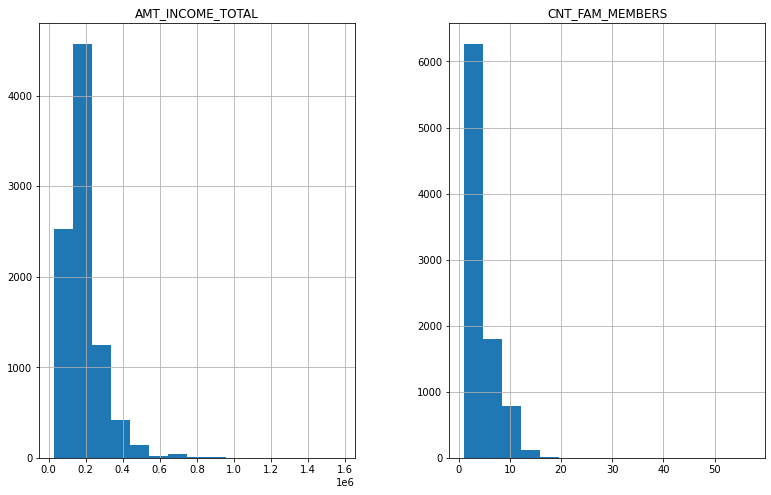

In [75]:
_ = clean_app_data[['AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS']].hist(bins=15, figsize=(13,8))

The distributions here are largely skewed to the left.

## Categorical data exploration

In [76]:
cat_vars = [var for var in clean_app_data.columns if clean_app_data[var].dtype == 'O']
cat_vars

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'FLAG_MOBIL',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'EMPLOYED_YN']

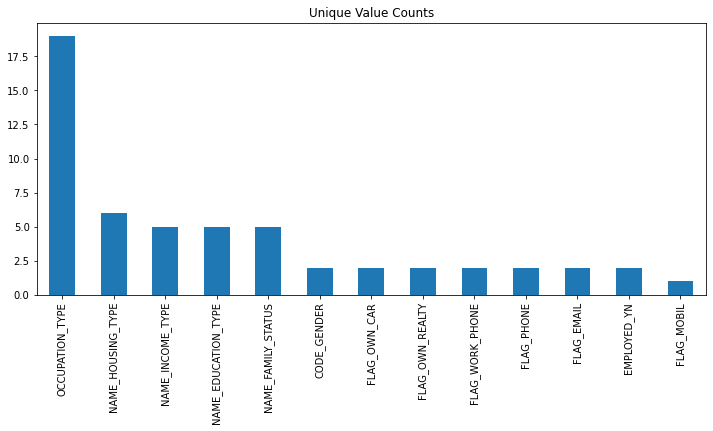

In [77]:
_ = clean_app_data[cat_vars].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5), title='Unique Value Counts')

In [81]:
import matplotlib.pyplot as plt

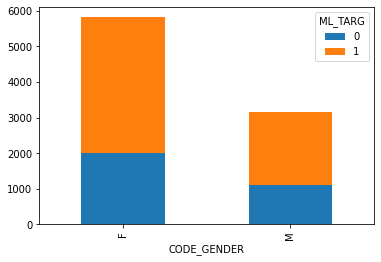

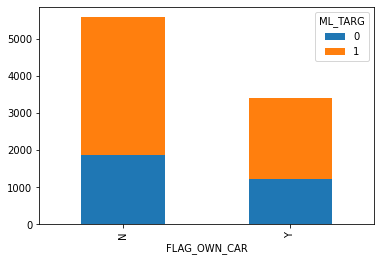

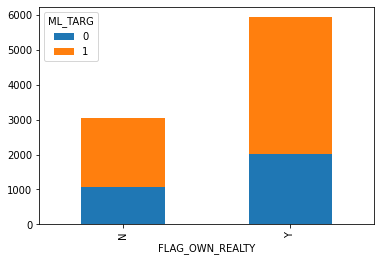

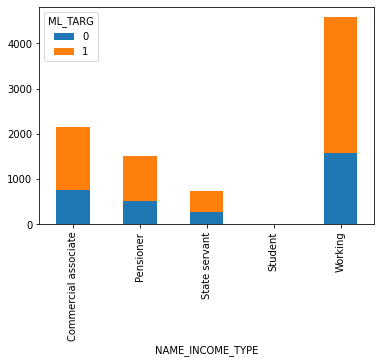

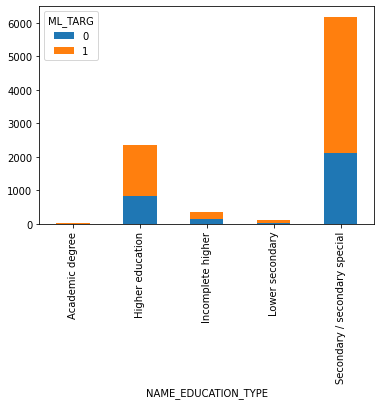

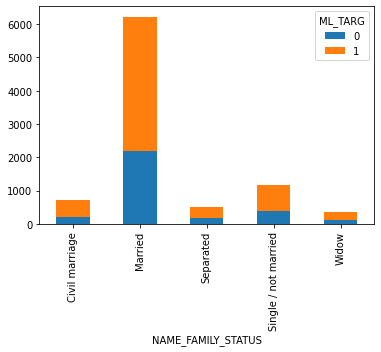

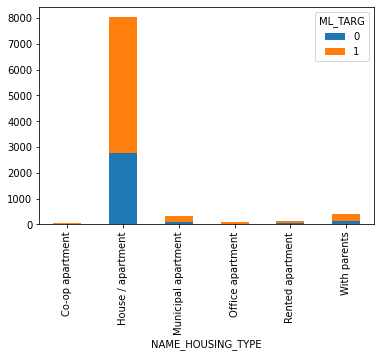

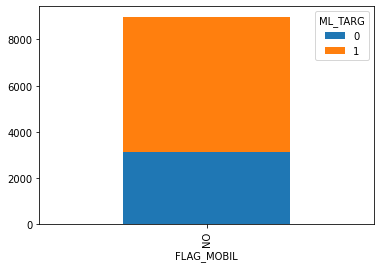

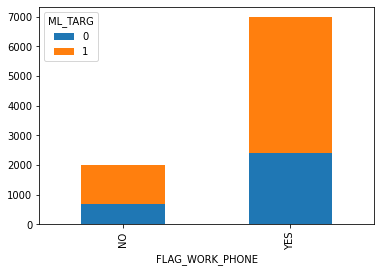

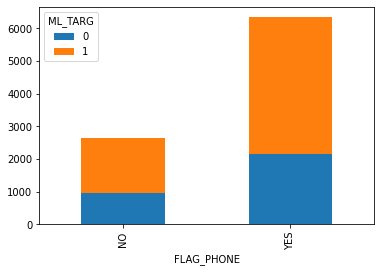

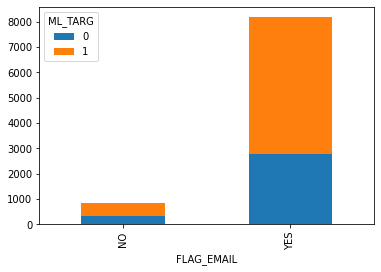

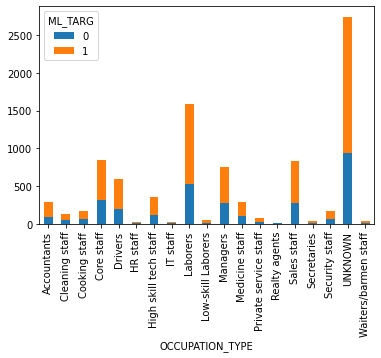

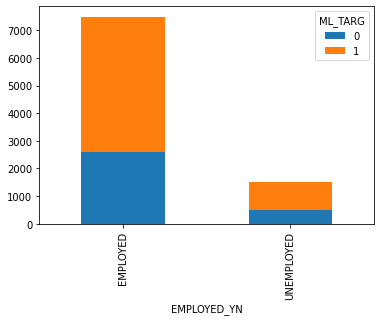

In [82]:
# clean_app_data.groupby(['OCCUPATION_TYPE','ML_TARG']).size().unstack().plot(kind='bar', stacked=True)
for cat in cat_vars:
    clean_app_data.groupby([cat,'ML_TARG'])\
        .size()\
        .unstack()\
        .plot(kind='bar', stacked=True)

    plt.show()

In [85]:
clean_app_data['ML_TARG'].value_counts()/len(clean_app_data)

1    0.655253
0    0.344747
Name: ML_TARG, dtype: float64

From the plots it looks like the `FLAG_MOBIL` is redundant. We will remove it along with `DUPE`.

In [84]:
clean_app_data.drop(['DUPE', 'FLAG_MOBIL'], axis='columns', inplace=True)

Some insights from the plots

- There are only a few applicants who are still `Students`.
- There are only few applicants with `Academic Degree` and most applicants have `secondary education`
- There is a clear correlation between, if an applicant is `employed or not` and the target.
- Overall the targets are quite balanced (66-34).

## Save clean and interpretable data

In [86]:
clean_app_data.to_csv('/content/clean_data_filt.csv', index=False)

# Training with clean data

In [90]:
!pip install imodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 194 kB 7.8 MB/s 
     |████████████████████████████████| 1.3 MB 51.4 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [164]:
np.random.seed(42)

In [167]:
train_data = pd.read_csv('/content/clean_data_filt.csv')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8995 entries, 0 to 8994
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   8995 non-null   int64  
 1   CODE_GENDER          8995 non-null   object 
 2   FLAG_OWN_CAR         8995 non-null   object 
 3   FLAG_OWN_REALTY      8995 non-null   object 
 4   AMT_INCOME_TOTAL     8995 non-null   float64
 5   NAME_INCOME_TYPE     8995 non-null   object 
 6   NAME_EDUCATION_TYPE  8995 non-null   object 
 7   NAME_FAMILY_STATUS   8995 non-null   object 
 8   NAME_HOUSING_TYPE    8995 non-null   object 
 9   FLAG_WORK_PHONE      8995 non-null   object 
 10  FLAG_PHONE           8995 non-null   object 
 11  FLAG_EMAIL           8995 non-null   object 
 12  OCCUPATION_TYPE      8995 non-null   object 
 13  CNT_FAM_MEMBERS      8995 non-null   float64
 14  ML_TARG              8995 non-null   int64  
 15  AGE                  8995 non-null   i

## Import required libraries

In [168]:
from imodels import RuleFitClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split

We should seperate the target and remove the `ID` variable.

In [169]:
train_data.drop('ID', axis='columns', inplace=True)

In [170]:
x_train, x_test, y_train, y_test = train_test_split(train_data.drop('ML_TARG', axis='columns'),
                                                    train_data['ML_TARG'], test_size=0.2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7196, 15), (7196,), (1799, 15), (1799,))

Filter Categories and numerical variables

In [171]:
categorical_ix = train_data.select_dtypes(include=['object', 'bool']).columns
categorical_ix

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'EMPLOYED_YN'],
      dtype='object')

In [172]:
numerical_ix = train_data.select_dtypes(include=['int64', 'float64']).columns
numerical_ix

Index(['AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS', 'ML_TARG', 'AGE'], dtype='object')

## Training setup

In [173]:
t = [('cat', OneHotEncoder(drop='first'), categorical_ix)]

col_transform = ColumnTransformer(transformers=t,
                                  remainder='passthrough',
                                  verbose_feature_names_out=True)

In [174]:
rclf = RuleFitClassifier()
pipeline = Pipeline(steps=[('prep',col_transform),
                           ('to_dense', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),])
                        #    ('m', rclf)])#, m__feature_names=col_transform['cat'].get_feature_names_out())

In [175]:
pipeline['prep']

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat', OneHotEncoder(drop='first'),
                                 Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'EMPLOYED_YN'],
      dtype='object'))])

In [176]:
pipeline.fit(x_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'EMPLOYED_YN'],
      dtype='object'))])),
                ('to_dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x7fa08c6361f0>))])

In [177]:
rclf.fit(pipeline['prep'].transform(x_train).toarray(), y_train,
         feature_names=pipeline['prep'].get_feature_names_out())

RuleFitClassifier()

## Trained Rules and Coeffs

In [178]:
print(rclf)

> ------------------------------
> RuleFit:
> 	Predictions are made by summing the coefficients of each rule
> ------------------------------
                                                                                                                                                                                            rule  coef
                                                                                                                                                                 cat__NAME_FAMILY_STATUS_Married -0.02
                                                                                                                                                                             cat__FLAG_EMAIL_YES  0.03
                                                                                                                                                                             cat__FLAG_PHONE_YES  0.04
                                                              

In [179]:
rclf.feature_names

array(['cat__CODE_GENDER_M', 'cat__FLAG_OWN_CAR_Y',
       'cat__FLAG_OWN_REALTY_Y', 'cat__NAME_INCOME_TYPE_Pensioner',
       'cat__NAME_INCOME_TYPE_State servant',
       'cat__NAME_INCOME_TYPE_Student', 'cat__NAME_INCOME_TYPE_Working',
       'cat__NAME_EDUCATION_TYPE_Higher education',
       'cat__NAME_EDUCATION_TYPE_Incomplete higher',
       'cat__NAME_EDUCATION_TYPE_Lower secondary',
       'cat__NAME_EDUCATION_TYPE_Secondary / secondary special',
       'cat__NAME_FAMILY_STATUS_Married',
       'cat__NAME_FAMILY_STATUS_Separated',
       'cat__NAME_FAMILY_STATUS_Single / not married',
       'cat__NAME_FAMILY_STATUS_Widow',
       'cat__NAME_HOUSING_TYPE_House / apartment',
       'cat__NAME_HOUSING_TYPE_Municipal apartment',
       'cat__NAME_HOUSING_TYPE_Office apartment',
       'cat__NAME_HOUSING_TYPE_Rented apartment',
       'cat__NAME_HOUSING_TYPE_With parents', 'cat__FLAG_WORK_PHONE_YES',
       'cat__FLAG_PHONE_YES', 'cat__FLAG_EMAIL_YES',
       'cat__OCCUPATION_TYPE

## Test and visualize predictions

In [180]:
from sklearn import metrics

def viz_classification_preds(probs, y_test):
    '''look at prediction breakdown
    '''
    plt.subplot(121)
    plt.hist(probs[:, 1][y_test == 0], label='Class 0')
    plt.hist(probs[:, 1][y_test == 1], label='Class 1', alpha=0.8)
    plt.ylabel('Count')
    plt.xlabel('Predicted probability of class 1')
    plt.legend()

    plt.subplot(122)
    preds = np.argmax(probs, axis=1)
    plt.title('ROC curve')
    fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.plot(fpr, tpr)
    plt.tight_layout()
    plt.show()


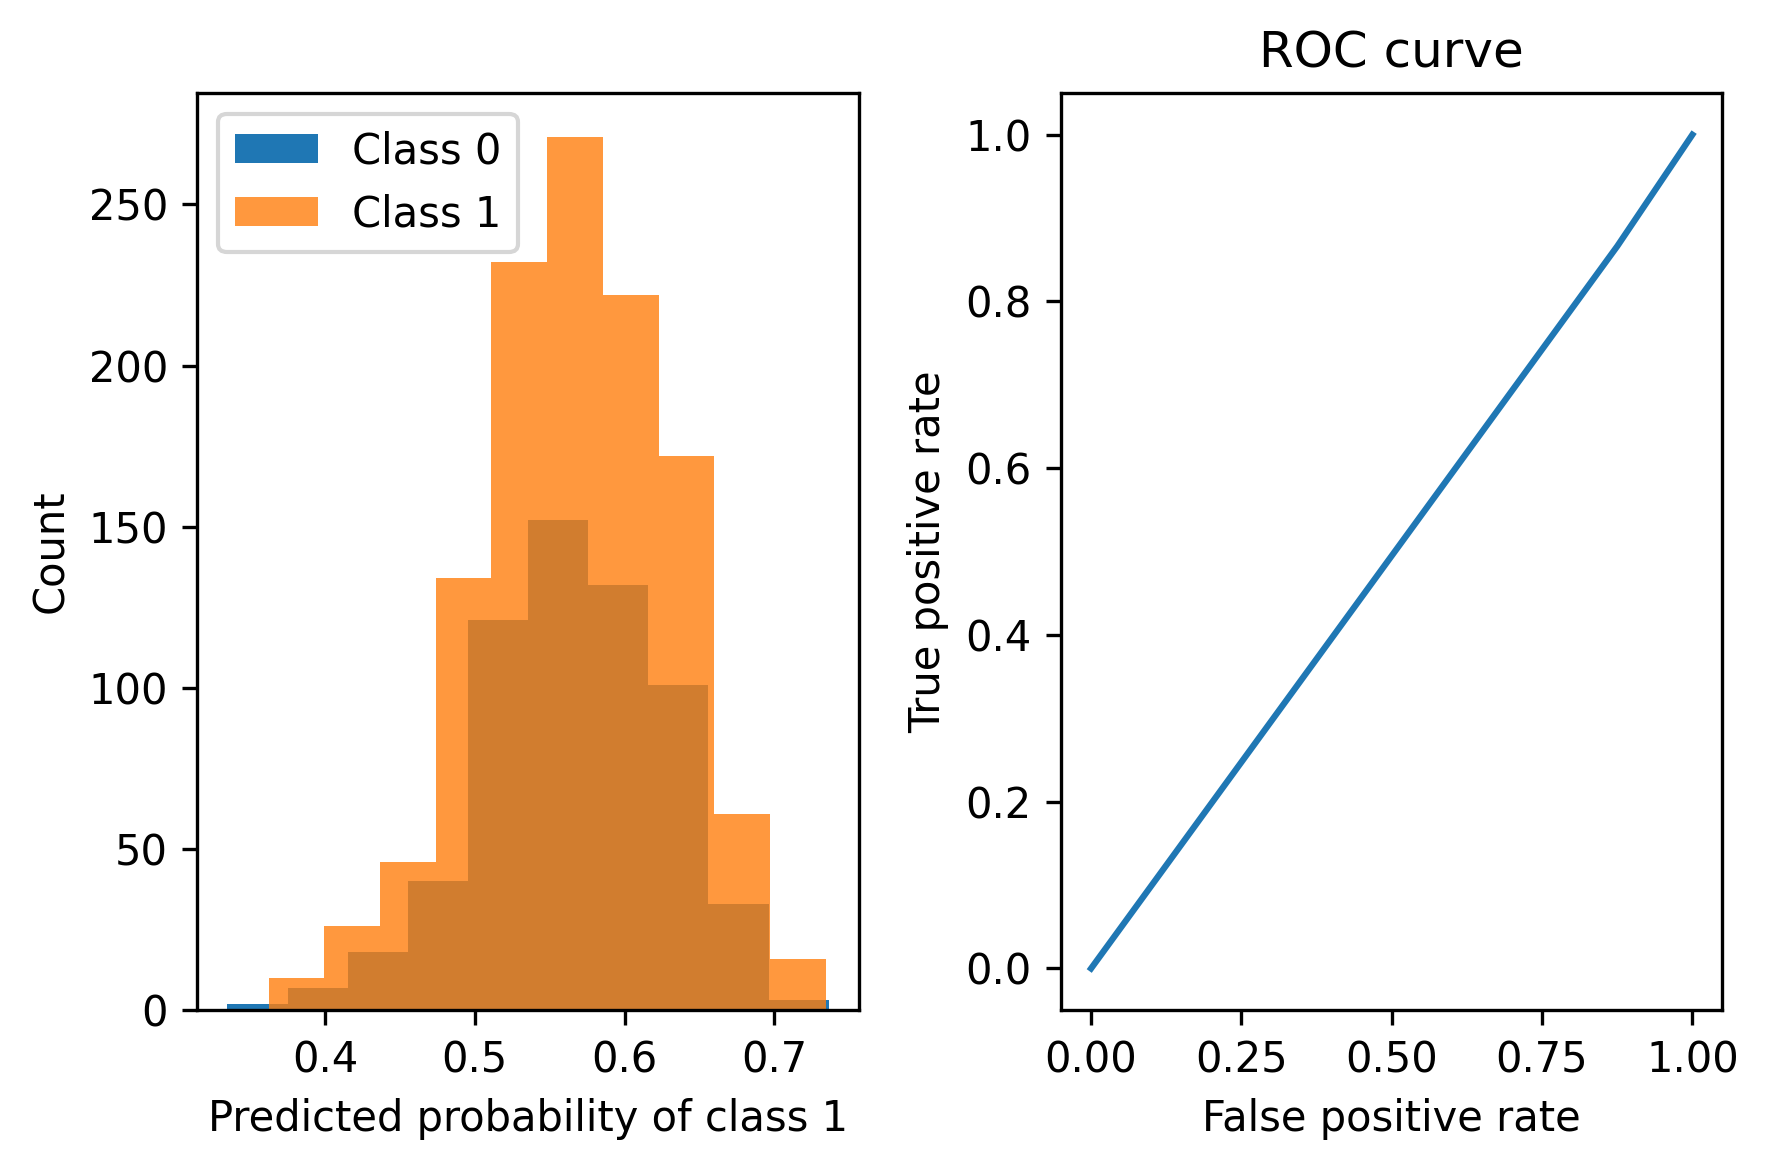

In [181]:
# rclf.fit(x_train, y_train)
probs = rclf.predict_proba(pipeline['prep'].transform(x_test).toarray())

# look at prediction breakdown
viz_classification_preds(probs, y_test)

y_pred = rclf.predict(pipeline['prep'].transform(x_test).toarray())

## Evalutation scores

In [182]:
print(metrics.classification_report(y_test, y_pred, target_names=['BAD', 'GOOD']))

              precision    recall  f1-score   support

         BAD       0.32      0.12      0.18       609
        GOOD       0.66      0.87      0.75      1190

    accuracy                           0.62      1799
   macro avg       0.49      0.50      0.46      1799
weighted avg       0.55      0.62      0.56      1799

